<a href="https://colab.research.google.com/github/leoscarlato/paradigmas-resolvidos/blob/main/PARADIGMAS%20-%20AULA%2005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LINGUAGENS E PARADIGMAS - AULA 05**

**Prof. Luciano Silva**

**OBJETIVOS DA AULA:**

*   Iniciar o estudo do analisador semântico
*   Entender o processo de decoração da árvore sintática
*   Aplicar o design pattern Visitor para realizar o processo de decoração da árvore sintática


In [1]:
!pip install rply

**ANALISADOR SEMÂNTICO**

O análise semântica é o terceiro passo no processo de compilação e é realizada pelo **analisador semântico**.

<img src="https://www.researchgate.net/profile/Nuno-Oliveira-15/publication/266497079/figure/fig1/AS:295651775664128@1447500284302/Common-Compiler-Phases.png"> <img>

O analisador semântico realiza diversas operações como, por exemplo, decoração da árvore sintática, verificação de tipos e verificação de chamadas de procedimentos e funções.



**DECORAÇÃO DA ÁRVORE SINTÁTICA**

O objetivo da decoração da árvore sintática consiste em adicionar informações semânticas na árvore sintática (tipo, quantidade de parâmetros, contexto, etc) de forma a facilitar os passos seguintes da análise semântica.

Por exemplo, para o processo de verificação de tipos, precisamos ter todos os nós da árvore sintática (relacionados com tipos) com os seu respectivos tipos decorados na árvore. Na chamada de um procedimento e função, precisamos saber se estamos usando o número correto de parâmetros e estamos usando seus tipos corretamente.

Abaixo, temos um exemplo de erro semântico:

**int x=1,y;**

**string nome="maria";**

**y=x+nome;**

Observe que não há erro sintático. Porém, ao tentarmos somar x(inteiro) com nome(string), teremos uma incompatibilidade de tipos na soma. Para tratar isto, fazemos o processo em três passos:

(1) montamos uma **tabela de símbolos** com a declaração das variáveis:

<table>
<tr> <td> <b>id</b> </td> <td> <b>type</b> </td> </tr>
<tr> <td> x </td> <td> int </td> </tr>
<tr> <td> y </td> <td> int </td> </tr>
<tr> <td> nome </td>  <td> string </td>  </tr>
</table>

(2) decoramos os nós da árvore relativos à expressão aritmética:

**y<font color="red">(int)</font>=x<font color="red">(int)</font>+nome<font color="red">(string)</font>;**

(3) no operador de soma, verificamor que os operandos x<font color="red">(int)</font> e nome<font color="red">(string)</font> são incompatíveis.

**Cada um destes passos é realizado por um Visitor.**


**EXERCÍCIO**

Abaixo, temos uma gramática com expressões aritméticas envolvendo números inteiro (type = int).

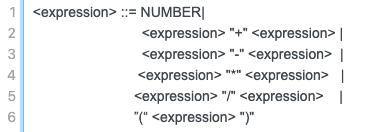

Abaixo, temos a implementação do analisador léxico para esta gramática:

In [2]:
from rply import LexerGenerator

lg = LexerGenerator()

lg.add('NUMBER', r'\d+')
lg.add('PLUS', r'\+')
lg.add('MINUS', r'-')
lg.add('MUL', r'\*')
lg.add('DIV', r'/')
lg.add('OPEN_PARENS', r'\(')
lg.add('CLOSE_PARENS', r'\)')

lg.ignore('\s+')

lexer = lg.build()

A seguir, temos a implementação das classes dos nós da árvore sintática, já com o método accept para receber os visitors:

In [3]:
from rply.token import BaseBox

class Expr(BaseBox):
    def accept(self, visitor):
        method_name = 'visit_{}'.format(self.__class__.__name__.lower())
        visit = getattr(visitor, method_name)
        return visit(self)

class Number(Expr):
    def __init__(self, value):
        self.value = value


class BinaryOp(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOp):
  pass


class Sub(BinaryOp):
  pass


class Mul(BinaryOp):
  pass


class Div(BinaryOp):
  pass



A seguir, temos um visitor que percorre a árvore sintática e resolve a expressão contida nela:

In [4]:
class Visitor(object):
    pass


class Eval(Visitor):
    def visit_number(self, i):
        return i.value

    def visit_add(self, a):
        return a.left.accept(self) + a.right.accept(self)

    def visit_sub(self, a):
        return a.left.accept(self) - a.right.accept(self)

    def visit_mul(self, a):
        return a.left.accept(self) * a.right.accept(self)

    def visit_div(self, a):
        return a.left.accept(self) / a.right.accept(self)


Finalmente, temos o analisador sintático:

In [5]:
from rply import ParserGenerator

pg = ParserGenerator(
    # A list of all token names, accepted by the lexer.
    ['NUMBER', 'OPEN_PARENS', 'CLOSE_PARENS',
     'PLUS', 'MINUS', 'MUL', 'DIV'
    ],
    # A list of precedence rules with ascending precedence, to
    # disambiguate ambiguous production rules.
    precedence=[
        ('left', ['PLUS', 'MINUS']),
        ('left', ['MUL', 'DIV'])
    ]
)

@pg.production('expression : NUMBER')
def expression_number(p):
    # p is a list of the pieces matched by the right hand side of the
    # rule
    return Number(int(p[0].getstr()))

@pg.production('expression : OPEN_PARENS expression CLOSE_PARENS')
def expression_parens(p):
    return p[1]

@pg.production('expression : expression PLUS expression')
@pg.production('expression : expression MINUS expression')
@pg.production('expression : expression MUL expression')
@pg.production('expression : expression DIV expression')
def expression_binop(p):
    left = p[0]
    right = p[2]
    if p[1].gettokentype() == 'PLUS':
        return Add(left, right)
    elif p[1].gettokentype() == 'MINUS':
        return Sub(left, right)
    elif p[1].gettokentype() == 'MUL':
        return Mul(left, right)
    elif p[1].gettokentype() == 'DIV':
        return Div(left, right)
    else:
        raise AssertionError('Oops, this should not be possible!')

parser = pg.build()

Para testar o visitor, fazemos a análise sintática, geramos a árvore sintática e, finalmente, passamos o visitor de resolução a ela:

In [6]:
arvore=parser.parse(lexer.lex('1+2*5'))
print(arvore.accept(Eval()))

11


Implemente e teste um visitor para decorar esta árvore sintática, utilizando o seguinte conjunto de regras de tipo:

NUMBER --> int

int + int --> int

int - int --> int

int * int --> int

int / int --> int


In [7]:
class Decorator(Visitor):
    def visit_number(self, i):
        i.decor_type="int"



    def visit_add(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"


    def visit_sub(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_mul(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_add(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

In [8]:
arvore.accept(Decorator())
print(arvore.decor_type)


int


**EXERCÍCIO**

A gramática abaixo aumenta a gramática vista em aula e acrescenta declaração de variáveis com os tipos int e string, assim como um comando de atribuição.

(1) implemente um visitor para montar a tabela de símbolos

(2) implemente um visitor para decorar a árvore sintática. Suponha que NUMBER tenha o tipo int.


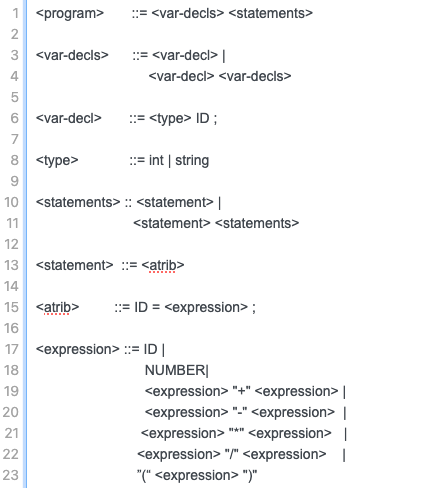

In [69]:
#ANALISADOR LÉXICO

from rply import LexerGenerator

lg = LexerGenerator()

lg.add('NUMBER', r'\d+')
lg.add('PLUS', r'\+')
lg.add('MINUS', r'-')
lg.add('MUL', r'\*')
lg.add('DIV', r'/')
lg.add('OPEN_PARENS', r'\(')
lg.add('CLOSE_PARENS', r'\)')

lg.add('INT', r'int')
lg.add('STRING', r'string')
lg.add('ID', r'[a-zA-Z][a-zA-Z0-9]*')
lg.add('EQUALS', r'=')
lg.add('SEMICOL', r';')

lg.ignore('\s+')

lexer = lg.build()

In [75]:
#ÁRVORE SINTÁTICA PREPARADA PARA RECEBER VISITORS

from rply.token import BaseBox

class Prog(BaseBox):
    def __init__(self, decls,stmts):
        self.decls = decls
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_prog(self)

class VarDecls(BaseBox):
    def __init__(self, decl,decls):
        self.decl = decl
        self.decls = decls

    def accept(self, visitor):
        visitor.visit_vardecls(self)

class VarDecl(BaseBox):
    def __init__(self, id,tp):
        self.id = id
        self.tp = tp


    def accept(self, visitor):
        visitor.visit_vardecl(self)

class Statements(BaseBox):
    def __init__(self, stmt,stmts):
        self.stmt = stmt
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_statements(self)

class Statement(BaseBox):
    def __init__(self,atrib):
        self.atrib = atrib

    def accept(self, visitor):
        visitor.visit_statement(self)

class Atrib(BaseBox):
    def __init__(self, id,expr):
        self.id = id
        self.expr = expr

    def accept(self, visitor):
        visitor.visit_atrib(self)

class Expr(BaseBox):
    def accept(self, visitor):
        method_name = 'visit_{}'.format(self.__class__.__name__.lower())
        visit = getattr(visitor, method_name)
        visit(self)

class Id(Expr):
    def __init__(self, value):
        self.value = value

class Number(Expr):
    def __init__(self, value):
        self.value = value


class BinaryOp(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOp):
  pass


class Sub(BinaryOp):
  pass


class Mul(BinaryOp):
  pass


class Div(BinaryOp):
  pass

In [76]:
#ANALISADOR SINTÁTICO

from rply import ParserGenerator

pg = ParserGenerator(
    # A list of all token names, accepted by the lexer.
    ['NUMBER', 'OPEN_PARENS', 'CLOSE_PARENS',
     'PLUS', 'MINUS', 'MUL', 'DIV', 'INT', 'STRING', 'ID','SEMICOL',
     'EQUALS'
    ],
    # A list of precedence rules with ascending precedence, to
    # disambiguate ambiguous production rules.
    precedence=[
        ('left', ['PLUS', 'MINUS']),
        ('left', ['MUL', 'DIV'])
    ]
)

@pg.production('prog : vardecls statements')
def prog(p):
    return Prog(p[0],p[1])

@pg.production('vardecls : vardecl')
def vardecls(p):
    return VarDecls(p[0],None)

@pg.production('vardecls : vardecl vardecls')
def vardecls(p):
    return VarDecls(p[0],p[1])

@pg.production('vardecl : STRING ID SEMICOL')
def vardecl_string(p):
    return VarDecl(p[1].getstr(), "string")

@pg.production('vardecl : INT ID SEMICOL')
def vardecl_int(p):
    return VarDecl(p[1].getstr(), "int")

@pg.production('statements : statement')
def statements_statement(p):
    return Statements(p[0],None)

@pg.production('statements : statement statements')
def statement_statements(p):
    return Statements(p[0],p[1])

@pg.production('statement : atrib')
def statement_atrib(p):
    return Statement(p[0])

@pg.production('atrib : ID EQUALS expression SEMICOL')
def atrib(p):
    return Atrib(p[0].getstr(),p[2])


@pg.production('expression : ID')
def expression_id(p):
    return Id(p[0].getstr())

@pg.production('expression : NUMBER')
def expression_number(p):
    return Number(int(p[0].getstr()))

@pg.production('expression : OPEN_PARENS expression CLOSE_PARENS')
def expression_parens(p):
    return p[1]

@pg.production('expression : expression PLUS expression')
@pg.production('expression : expression MINUS expression')
@pg.production('expression : expression MUL expression')
@pg.production('expression : expression DIV expression')
def expression_binop(p):
    left = p[0]
    right = p[2]
    if p[1].gettokentype() == 'PLUS':
        return Add(left, right)
    elif p[1].gettokentype() == 'MINUS':
        return Sub(left, right)
    elif p[1].gettokentype() == 'MUL':
        return Mul(left, right)
    elif p[1].gettokentype() == 'DIV':
        return Div(left, right)
    else:
        raise AssertionError('Oops, this should not be possible!')

parser = pg.build()

In [77]:
arvore=parser.parse(lexer.lex('int x;int y;int z;z=x+y;'))

In [78]:
ST={}  #TABELA DE SÍMBOLOS É UM DICIONÁRIO (ID, TIPO)

class Visitor(object):
  pass

class SymbolTable(Visitor):
    def visit_prog(self, prog):
        prog.decls.accept(self)

    def visit_vardecls(self, d):
        d.decl.accept(self)
        if d.decls!=None:
          d.decls.accept(self)

    def visit_vardecl(self, d):
        ST[d.id]=d.tp

In [79]:
arvore.accept(SymbolTable())
for id, tp in ST.items():
  print(id, tp)

x int
y int
z int


In [80]:
# VISITOR - DECORATOR

class Decorator(Visitor):

    def visit_prog(self, i):
        i.stmts.accept(self)

    def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)

    def visit_statement(self, d):
        d.atrib.accept(self)

    def visit_atrib(self, i):
        if i.id in ST:
          i.id_decor_type=ST[i.id]
        else:
          raise AssertionError('id not declared')
        i.expr.accept(self)
        i.expr_decor_type=i.expr.decor_type

    def visit_id(self, i):
        if i.value in ST:
          i.decor_type=ST[i.value]
        else:
          raise AssertionError('id not declared')


    def visit_number(self, i):
        i.decor_type="int"


    def visit_add(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"


    def visit_sub(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_mul(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_div(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

In [81]:
arvore.accept(Decorator())